   # CLUSTERING OF COPENHAGEN STATIONS 

# Introduction



Copenhagen, the Capital of Denmark,  has today 125 metro and train stations. Government is discussing building 4 new metro stations and 2 new train stations..

S Train (alone) is used annually by more than 116 million people (2016 figure) whereas 220 thousands residents take Copenhagen metro daily to their work.

Following decades of urban development, it is worthwhile to take a snapshot of the current development of areas surrounding metro and train stations and classify them into groups. 
Some neighbourhoods are commonly known, especially for Copenhagen residents, as mostly residential, others have more business and commercial spaces surrounding them. The purpose of this work is to let data tell the story. 

The venues closest to a station determine why and how people use it. e.g. if there are low counts of professional places in a neighbourhood then its residents are likely to commute to other areas for work. This creates daily movement of people.
 

## Target Audience
By analyzing this data we can classify stations by their primary usage. This data is useful for:
<ul>
    <li>City planners to tell how people are most likely to move around in the city for work or just to rewind. This also can help plan further extension of the transport network
    <li> Someone looking to decide on their residence area. This analysis provides an insight on the blend of venues around each stations. 
         </ul>
moreover,
<ul>
    <li> It helps businesses determine locations that best suits nature of their business.
    <li> Curious souls like mine....     
         </ul>
         
## Data: 
 
For this project, I need data on stations (train and metro) and on the venues around them.


<ol>
<li>List of transport stations are available on Wikipedia page,
        
For metro network, it is [HERE]( https://en.wikipedia.org/wiki/List_of_Copenhagen_Metro_stations). 
For train network,  it is [HERE]( https://en.wikipedia.org/wiki/List_of_Copenhagen_S-train_stations) 
    
<li>Foursquare API to explore counts of venue categories surrounding each station.
<li>Foursquare Venue Category Hierarchy. Foursquare groups venues in high-level categories then those are broken down to sub-categories.
        

This list is available 
    [HERE]( https://developer.foursquare.com/docs/build-with-foursquare/categories/)  

</ol>


We’ll be querying the number of venues in each category in a 1000m radius around each station. This radius was chosen because 1000m is a reasonable walking distance.
   

# 1 Importing Libraries and Transport Datasets 

All libraries needed for the projects are imported in this steps.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means and preprocessing for clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing

!conda install -c conda-forge folium=0.11 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns
import matplotlib.pyplot as plt


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1.1 Metro Stations dataset

Scrapping Metro stations (and future ones) information from wikipedia page and store them in CSV file. 

In [27]:
url = "https://en.wikipedia.org/wiki/List_of_Copenhagen_Metro_stations"

r = requests.get(url)
df_list = pd.read_html(r.text) # this parses all the tables in webpages to a list
Metro_stations = df_list[1]
Metro_stations = Metro_stations.drop(columns=["Time to Nørreport (M1 and M2)", "Transfer", "Grade"])
Future_Metro_stations = df_list[2]
Future_Metro_stations = Future_Metro_stations.drop(columns=["Transfer"])

#get rid of the noise in data
for i in range(Metro_stations.shape[0]):
    if Metro_stations.iloc[i,0].endswith('#'):
        Metro_stations.iloc[i,0]= Metro_stations.iloc[i,0].replace('#','')
    elif Metro_stations.iloc[i,0].endswith('†'):
        Metro_stations.iloc[i,0]= Metro_stations.iloc[i,0].replace('†','')
        
        

Creating new dataframe to fill them with coordindates

In [ ]:
newdf= pd.DataFrame( columns=['Latitude', 'Longitude'])
newdf1= pd.DataFrame( columns=['Latitude', 'Longitude'])
newdf2= pd.DataFrame( columns=['Latitude', 'Longitude'])
newdf3= pd.DataFrame( columns=['Latitude', 'Longitude'])

Iterating through google geocode to get the coordinates of each station. (on multiple takes as there is a specific request qouta)

In [ ]:
geolocator = Nominatim(user_agent="Cph_explorer")
for i in range( 14, Metro_stations.shape[0]):
    location = geolocator.geocode('{} Station, Denmark'.format(Metro_stations.iloc[i,0]))
    if location != None:
            newdf.loc[i,'Latitude'] = location.latitude
            newdf.loc[i,'Longitude']= location.longitude
    else:
            print(Metro_stations.iloc[i,0])
            location = geolocator.geocode('{}, Denmark'.format(Metro_stations.iloc[i,0]))
            newdf.loc[i,'Latitude'] = location.latitude
            newdf.loc[i,'Longitude']= location.longitude
Metro_stations=pd.concat([Metro_stations,newdf], axis=1)
Metro_stations.iloc[29,4]=55.6616667 
Metro_stations.iloc[29,5]=12.6286111
Metro_stations.to_csv('Metro_stations.csv')  # store Metro Stations information in csv.

for i in range(Future_Metro_stations.shape[0]):
    location = geolocator.geocode('{} Station, Denmark'.format(Future_Metro_stations.iloc[i,0]))
    if location != None:
            newdf1.loc[i,'Latitude'] = location.latitude
            newdf1.loc[i,'Longitude']= location.longitude
    else:
            print(Future_Metro_stations.iloc[i,0])
Future_Metro_stations=pd.concat([Future_Metro_stations,newdf1], axis=1)
Future_Metro_stations.to_csv('Future_Metro_stations.csv') # store Future Metro Stations information in csv.

## 1.2 Train Stations dataset

Same goes for train stations, scrapping info from wiki page, cleaning then iterating through google geocode to get the coordinates of each station. 

In [ ]:
url2 = "https://en.wikipedia.org/wiki/List_of_Copenhagen_S-train_stations"

r2 = requests.get(url2)
df_list2 = pd.read_html(r2.text) # this parses all the tables in webpages to a list
Train_stations = df_list2[1]
Train_stations = Train_stations.drop(columns=["Time", "Transfer"])
Future_Train_stations = df_list2[2]
Future_Train_stations = Future_Train_stations.drop(columns=["Time", "Transfer"])

for i in range(Train_stations.shape[0]):
    if Train_stations.iloc[i,0].endswith('#'):
        Train_stations.iloc[i,0]= Train_stations.iloc[i,0].replace('#','')
    elif Train_stations.iloc[i,0].endswith('†'):
        Train_stations.iloc[i,0]= Train_stations.iloc[i,0].replace('†','')
for i in range(Future_Train_stations.shape[0]):
    if Future_Train_stations.iloc[i,0].endswith('[3]'):
        Future_Train_stations.iloc[i,0]= Future_Train_stations.iloc[i,0].replace('[3]','')
    elif Future_Train_stations.iloc[i,0].endswith('[4]'):
        Future_Train_stations.iloc[i,0]= Future_Train_stations.iloc[i,0].replace('[4]','')

In [ ]:
geolocator = Nominatim(user_agent="Cph_explorer")
for i in range(12, Train_stations.shape[0]):
    location = geolocator.geocode('{} Station, Denmark'.format(Train_stations.iloc[i,0]))
    if location != None:
            newdf2.loc[i,'Latitude'] = location.latitude
            newdf2.loc[i,'Longitude']= location.longitude
    else:
            print(Train_stations.iloc[i,0])
            location = geolocator.geocode('{}, Denmark'.format(Train_stations.iloc[i,0]))
            newdf2.loc[i,'Latitude'] = location.latitude
            newdf2.loc[i,'Longitude']= location.longitude

Train_stations=pd.concat([Train_stations,newdf2], axis=1)
Train_stations.to_csv('Train_stations.csv')   #save train station to csv

for i in range(Future_Train_stations.shape[0]):
    location = geolocator.geocode('{} Station, Denmark'.format(Future_Train_stations.iloc[i,0]))
    if location != None:
        newdf3.loc[i,'Latitude'] = location.latitude
        newdf3.loc[i,'Longitude']= location.longitude
    else:
        print(Future_Train_stations.iloc[i,0])
        location = geolocator.geocode('{}, Denmark'.format(Future_Train_stations.iloc[i,0]))
        newdf3.loc[i,'Latitude'] = location.latitude
        newdf3.loc[i,'Longitude']= location.longitude
Future_Train_stations=pd.concat([Future_Train_stations,newdf3], axis=1)
Future_Train_stations.to_csv('Future_Train_stations.csv')  #save future train station to csv

After doing above, I convert them to markdown cells to avoid re-runs and start my daily work running below cells where I call the results of my above work. 

In [23]:
Metro_stations=pd.read_csv('Metro_stations.csv')
Metro_stations.iloc[20,5]=55.6308333    #SOME COORINDATES WERE OFF SO I NEEDED TO INTERVENE AND FIX MANUALLY
Metro_stations.iloc[20,6]=12.6491667
Metro_stations.iloc[34,5]=55.645222
Metro_stations.iloc[34,6]=12.58575
Metro_stations=Metro_stations.drop(columns=['Unnamed: 0'])
Future_Metro_stations=pd.read_csv('Future_Metro_stations.csv')
Future_Metro_stations=Future_Metro_stations.drop(columns=['Unnamed: 0'])
Train_stations=pd.read_csv('Train_stations.csv')
Train_stations=Train_stations.drop(columns=['Unnamed: 0'])
Future_Train_stations=pd.read_csv('Future_Train_stations.csv')
Future_Train_stations=Future_Train_stations.drop(columns=['Unnamed: 0'])
Future_Train_stations=Future_Train_stations.rename(columns={"Future station": "Station"})

#replacing danish special character with english letters
for i in range(Metro_stations.shape[0]):
    if "ø" in Metro_stations.iloc[i,0]:
        Metro_stations.iloc[i,0]=Metro_stations.iloc[i,0].replace("ø", "oe")
    elif "æ" in Metro_stations.iloc[i,0]:
        Metro_stations.iloc[i,0]=Metro_stations.iloc[i,0].replace("æ", "ae")
    elif "å" in Metro_stations.iloc[i,0]:
        Metro_stations.iloc[i,0]=Metro_stations.iloc[i,0].replace("å", "aa")
    elif "é" in Metro_stations.iloc[i,0]:
        Metro_stations.iloc[i,0]=Metro_stations.iloc[i,0].replace("é", "ee")
        
for i in range(Train_stations.shape[0]):
    if "ø" in Train_stations.iloc[i,0]:
        Train_stations.iloc[i,0]=Train_stations.iloc[i,0].replace("ø", "oe")
    elif "æ" in Train_stations.iloc[i,0]:
        Train_stations.iloc[i,0]=Train_stations.iloc[i,0].replace("æ", "ae")
    elif "å" in Train_stations.iloc[i,0]:
        Train_stations.iloc[i,0]=Train_stations.iloc[i,0].replace("å", "aa")
    elif "é" in Train_stations.iloc[i,0]:
        Train_stations.iloc[i,0]=Train_stations.iloc[i,0].replace("é", "ee")

## 1.3 Merging Metro and Train data in TRANSPORT DATA

Final <b>Trasnport Dataframe</b>  is made here

In [247]:
Transport_data=Metro_stations.append([Future_Metro_stations, Train_stations, Future_Train_stations], ignore_index=True)
Transport_data['Coordinates']=Transport_data['Latitude'].astype(str)+","+ Transport_data['Longitude'].astype(str)


In [248]:
Transport_data.shape

(131, 9)

# 1.4 Stations on CPH Map

Define coordinates of Copenhagen.. using them later to center the map.

In [24]:
geolocator = Nominatim(user_agent="Cph_explorer")
location = geolocator.geocode('Copenhagen, Denmark')
ltd = location.latitude
lntd = location.longitude
print('The geograpical coordinate of Copenhagen, the capital of Denmark, are {}, {}.'.format(ltd, lntd))

The geograpical coordinate of Copenhagen, the capital of Denmark, are 55.6867243, 12.5700724.


using folium library, put the stations on the map 

In [25]:
import branca
# create map of Copenhagen using latitude and longitude values
map_CPH = folium.Map(location=[ltd, lntd], zoom_start=10, tiles='Stamen Terrain')

# add markers to map
for lat, lng, Station, Line in zip(Train_stations['Latitude'], Train_stations['Longitude'], Train_stations['Station'], Train_stations['Line']):
    label = u'{} Train Station, Line: {}'.format(Station, Line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CPH) 
    
for lat, lng, Station, Line in zip(Metro_stations['Latitude'], Metro_stations['Longitude'], Metro_stations['Station'], Metro_stations['Line']):
    label = '{} Metro Station, Line: {}'.format(Station, Line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='PuBu',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CPH)
    
for lat, lng, Station, Line in zip(Future_Metro_stations['Latitude'], Future_Metro_stations['Longitude'], Future_Metro_stations['Station'], Future_Metro_stations['Line']):
    label = 'Future: {} Metro Station, Line: {}'.format(Station, Line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='PuBu',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CPH)  
    
for lat, lng, Station, Line in zip(Future_Train_stations['Latitude'], Future_Train_stations['Longitude'], Future_Train_stations['Station'], Future_Train_stations['Line']):
    label = 'Future: {} Train Station, Line: {}'.format(Station, Line)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='PuBu',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CPH)  
   
map_CPH

# 2 FourSqaure and Location Data

Using the station coordinates above, FourSquare will find categories for the surrounding venues.

## 2.1 List of FourSqaure Categories 

We need first to get the list of major venues categories. First, Passing **FourSqaure** Credentials


In [13]:
CLIENT_ID = 'SIBIHQFDK1SAYYZMIIFIKUHTBJOSRHSK1E42CBECAN3QGQLD' 
CLIENT_SECRET = 'B2LOXLDUNL4T1FBIUYEFTH5QAT22YSFF1MYA1NQWGDHOI4DV' 
VERSION = '20180605' 

Make the request for categories 

In [14]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [15]:
len(results['response']['categories']) #lengeth of the list 

10

There are 10 top-level categories and multiple subcategories. Possible subcategories is avaiable [HERE](https://developer.foursquare.com/docs/build-with-foursquare/categories/)


In [16]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## 2.2 Collect Counts of Venues Categories around CPH Stations

After having venues categories list, let's find the counts of these categories in 1 Km radius of transport stations. 

In [255]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

Iterate requests on several days to respect the max daily qouta of FourSqaure API request per day.

In [256]:
#Create new dataframe to store venues data
stations_venues_df = Transport_data.copy()
stations_venues_df=stations_venues_df.drop(columns=['Line','Opened','Zone','Grade','Opens'])
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [257]:
#Request number of venues, store result as CSV
from itertools import islice
for i, row in islice(stations_venues_df.iterrows(), 35, None):
    print(i)
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues_3.csv')

35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


KeyboardInterrupt: 

After iterating for days, data are stored in csv. files. we call files and merge them into one dataframe (Station_venues_df)

In [5]:
stations_venues_df1 = pd.read_csv('stations_venues.csv', index_col=0)
stations_venues_df3 = pd.read_csv('stations_venues_2.csv', index_col=0)
stations_venues_df2 = pd.read_csv('stations_venues_3.csv', index_col=0)
stations_venues_df1= stations_venues_df1.iloc[0:35,:]
stations_venues_df2= stations_venues_df2.iloc[35:81,:]
stations_venues_df3= stations_venues_df3.iloc[81:,:]

stations_venues_df=stations_venues_df1.append([stations_venues_df2, stations_venues_df3], ignore_index=True)
stations_venues_df.drop(columns=['Coordinates'], inplace= True)  

#replacing danish special character with english letters
for i in range(stations_venues_df.shape[0]):
    if "Ø" in stations_venues_df.iloc[i,0]:
        stations_venues_df.iloc[i,0]=stations_venues_df.iloc[i,0].replace("Ø", "Oe")
    elif "Æ" in stations_venues_df.iloc[i,0]:
        stations_venues_df.iloc[i,0]=stations_venues_df.iloc[i,0].replace("Æ", "Ae")
    elif "Å" in stations_venues_df.iloc[i,0]:
        stations_venues_df.iloc[i,0]=stations_venues_df.iloc[i,0].replace("Å", "Aa")
    elif "É" in stations_venues_df.iloc[i,0]:
        stations_venues_df.iloc[i,0]=stations_venues_df.iloc[i,0].replace("É", "Ee")
        
stations_venues_df.to_csv('stations_venues_P.csv')
stations_venues_df.head()


,Station,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aksel Moellers Have,55.686051,12.532947,8,53,0,94,27,37,47,3,69,13
1,Amager Strand,55.656135,12.631858,11,3,0,17,4,20,11,3,9,4
2,Amagerbro,55.663396,12.602895,4,42,0,67,15,28,28,16,61,12
3,Bella Center,55.638072,12.582932,4,3,0,34,5,11,43,4,73,11
4,Christianshavn,55.672374,12.588578,49,14,0,139,73,63,52,16,63,54


In [6]:
stations_venues_df = pd.read_csv('stations_venues_P.csv', index_col=0)


We have now the final counts of venues per station and we can proceed into clustering them. 

### 2.2.1 BoxPlot of Venues Categories


Using sns library, let's plot boxplot of venues categories. 

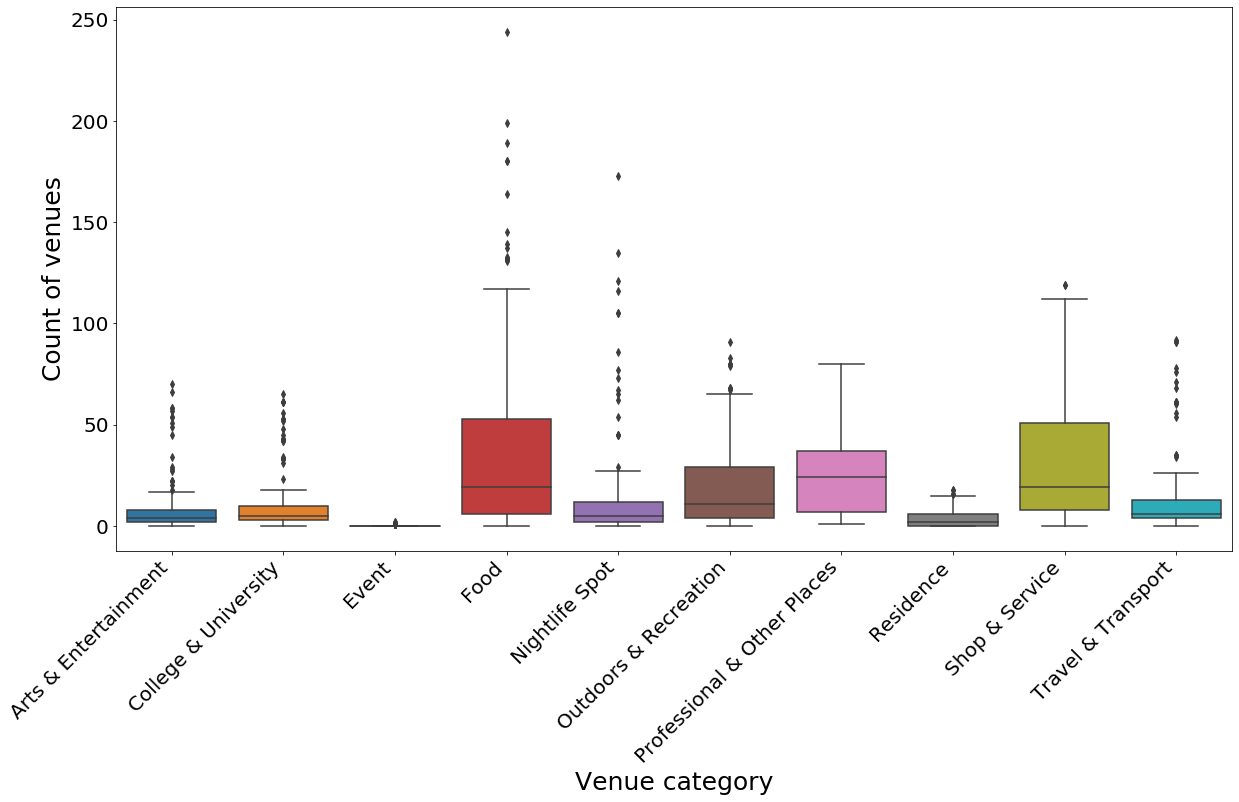

In [7]:
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df[stations_venues_df.columns[~stations_venues_df.columns.isin(['Latitude', 'Longitude'])]])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

I observe that **Food** venues have the highest count variability as well as the largest outliers.

Noticeably,  median for **Professional & Other Places** is the highest and it sets above medians of **Food and Shop&Service**.

**Food, nightlife spot and Shop&Service** have the most significant outliers counts among categories in few categories. 

**Food and Shop&Service**'s 75th percentile are the highest in the group and set slightly above 50 venues counts per category.  The interquartile range (IQR) of these two categories are the widest.


Venues that are categoried as **Event** are comperatively little therefore I delete it from the set. 


## 2.3 Clustering Stations

I followed **K-means** method in order to cluster the transport stations based upon its venue categories. 

 These were preliminary results with different number of clusters:

    2 clusters only show the uptown/downtown divide
    3 clusters add clustering within the downtown
    4 clusters also identify neighborhoods with very low number of venues
    5 and more clusters are difficult to interpret
For the final analysis let's settle on **4 clusters**.



In [8]:
# set number of clusters
kclusters = 4

#drop Event from venue category as its counts are marginal 
stations_venues_df_Clustering = stations_venues_df.drop(['Station','Event','Latitude', 'Longitude'], 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stations_venues_df_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 2, 2, 3, 0, 3, 3, 0, 2], dtype=int32)

now that we have the clusters, adding label to stations_venues_df dataframe.

In [9]:
# add clustering labels
stations_venues_df.insert(1, 'Cluster Labels', kmeans.labels_)

stations_venues_df.head() # check the first columns!

,Station,Cluster Labels,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aksel Moellers Have,3,55.686051,12.532947,8,53,0,94,27,37,47,3,69,13
1,Amager Strand,0,55.656135,12.631858,11,3,0,17,4,20,11,3,9,4
2,Amagerbro,2,55.663396,12.602894,4,42,0,67,15,28,28,16,61,12
3,Bella Center,2,55.638072,12.582932,4,3,0,34,5,11,43,4,73,11
4,Christianshavn,3,55.672374,12.588578,49,14,0,139,73,63,52,16,63,54


I normalized the counts in order to enjoy  better visualization and easier interpretation. This is done by scaling features to lie between zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved using **MinMaxScaler** available in sklearn library.

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(stations_venues_df.iloc[:,4:])
X_train_minmax = pd.DataFrame(X_train_minmax)
X_train_minmax.columns = [c[0] for c in categories_list]
stations_venues_df.iloc[:,4:]=X_train_minmax
stations_venues_df.drop(['Event'],1, inplace= True) #dropping event column to reduce noise
stations_venues_df.head()

,Station,Cluster Labels,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aksel Moellers Have,3,55.686051,12.532947,0.114286,0.815385,0.385246,0.156069,0.406593,0.582278,0.166667,0.579832,0.141304
1,Amager Strand,0,55.656135,12.631858,0.157143,0.046154,0.069672,0.023121,0.219780,0.126582,0.166667,0.075630,0.043478
2,Amagerbro,2,55.663396,12.602894,0.057143,0.646154,0.274590,0.086705,0.307692,0.341772,0.888889,0.512605,0.130435
3,Bella Center,2,55.638072,12.582932,0.057143,0.046154,0.139344,0.028902,0.120879,0.531646,0.222222,0.613445,0.119565
4,Christianshavn,3,55.672374,12.588578,0.700000,0.215385,0.569672,0.421965,0.692308,0.645570,0.888889,0.529412,0.586957


## 2.3.1 BoxPlot of Clusters Groups

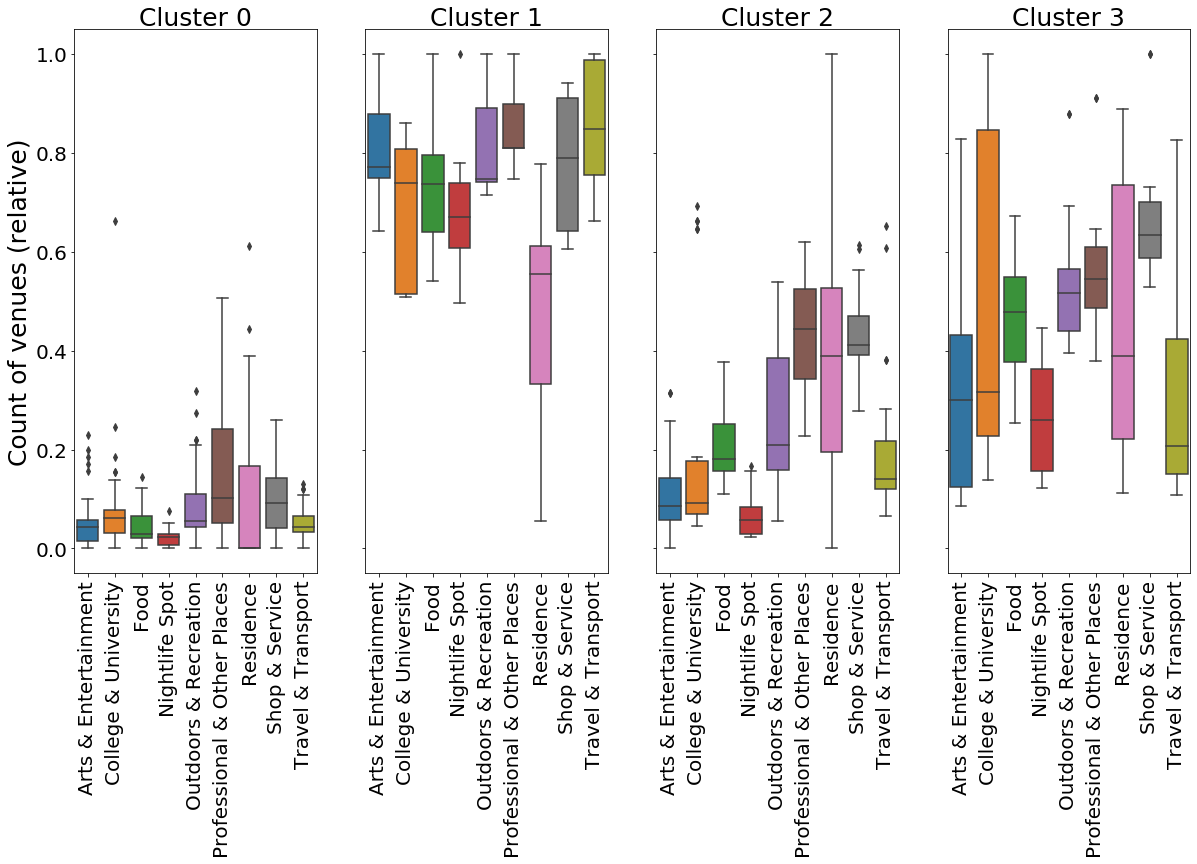

In [18]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    #Set same y axis limits
    #axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    condition=stations_venues_df['Cluster Labels']==k
    stations_venues_df_i=stations_venues_df[condition]
    stations_venues_df_i=stations_venues_df_i[stations_venues_df_i.columns[~stations_venues_df_i.columns.isin(['Cluster Labels','Latitude', 'Longitude'])]]
    sns.boxplot(data = stations_venues_df_i, ax=axes[k])

plt.show()

Map the data. For each station we'll display top 3 venue categories.

In [27]:
# create map
map_clusters = folium.Map(location=[ltd, lntd], zoom_start=10, tiles='Stamen Toner')
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_venues_df['Latitude'], stations_venues_df['Longitude'], stations_venues_df['Station'], stations_venues_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [300]:
map_clusters.save('map\index.html')

# 3 Results
We can characterize the clusters by looking at venue scores

<ul>
<li>Cluster 0 (Red) has the lowest marks across the board. This appears to be underdeveloped areas.
<li>Cluster 1 (Purple) has the highest scores for all venue categories. Noticeably most of their medians were above 0.6.  This is the most diversely developed part of the city.
<li>Cluster 2 (Blue) has comparatively low counts. Most significant venues counts in this cluster are Professional & Other Places, Residence and Outdoor& Recreation.    
<li>Cluster 3  (Green) has lower score than cluster 1, yet, it has the best scores in Residence and College & University.
</ul>
 
Plotting the clusters on a map shows us that
<ul>   
<li>Cluster 0 areas tend to be at the outskirts of Copenhagen.
<li>Cluster 1 is the oldest central part of the city
<li>Cluster 2 and Cluster 3 are intermingled. They are also downtown surrounding cluster 1. Most of these stations have excellent transit accessibility and there are many colleges have their campuses around and small to medium size company.
    
We notice also, one station "Lyngby", north of the Copenhagen, which is out of the city center, and is part of cluster 2. Many companies choose Lyngby to locate its premises. Lyngby is also the important shopping destination in the northern suburbs.
</ul>



# 4 Discussion
I dive through the different neighbourhood surrounding metro and train stations in Copenhagen. Results and data confirms my perceptions of these neighbourhood and what’s commonly known for Copenhagen residents.
The particularity of each clusters and the distribution of venues categories could help me personally choosing a location for residence. At the current time, I have the following selection criteria:
<ul>   
<li>Residential area with variety of food and outdoor recreation outlets. 
<li>And it provides options for entertainment and art.
</ul>

Going through the clusters, my preference goes to neighbourhoods around the stations in cluster 3.  

Yet, to be objective, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food, Shop & Service categories and outdoor & recreations. 
Also, data don’t take into account a venue’s capacity, popularity (e.g. a university building attracts a more people than a hot dog stand – each of them is still one Foursquare “venue”).


# 5	FUTURE DIRECTIONS 

<ul>   
<li>Results could be combined with other analysis (e.g. demographics, venues popularity/ capacity) to provide more accurate insights
<li> I excluded the bus station network from my study and this is definitively an area to further develop this work.
</ul>

    

# 6 CONCLUSIONS
Foursquare data is limited but can provide insights into a city’s development. Results could be combined with other analysis (e.g. demographics, venues popularity/capacity) to provide more accurate insights.
